In [8]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [44]:
import subprocess
import glob
from src.filter_worker import create_psf
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

In [33]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

filter = 'NIR-H'

In [34]:
files = glob.glob(f'{location}/{field}/{filter}_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]

In [35]:
subprocess.run([
    "sex",
    image_file,
    "-c", f"{location}/default_euclid.sex",
    "-CATALOG_NAME", f"{location}/{field}/psf.cat",
    "-PARAMETERS_NAME", f"{location}/psf.param",
    "-FILTER_NAME", f"{location}/default.conv",
], check=True)


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- SExtractor 2.28.2 started on 2026-02-18 at 14:56:25 with 8 threads

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for NIR-H_TILE102044185.fits
----- Measuring from: NIR-H_TILE102044185.fits
      "Unnamed" / no ext. header / 19200x19200 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up backgroun

CompletedProcess(args=['sex', '/net/vdesk/data2/deklerk/GAAP_data/53.0_-28.0/NIR-H_TILE102044185.fits', '-c', '/net/vdesk/data2/deklerk/GAAP_data/default_euclid.sex', '-CATALOG_NAME', '/net/vdesk/data2/deklerk/GAAP_data/53.0_-28.0/psf.cat', '-PARAMETERS_NAME', '/net/vdesk/data2/deklerk/GAAP_data/psf.param', '-FILTER_NAME', '/net/vdesk/data2/deklerk/GAAP_data/default.conv'], returncode=0)

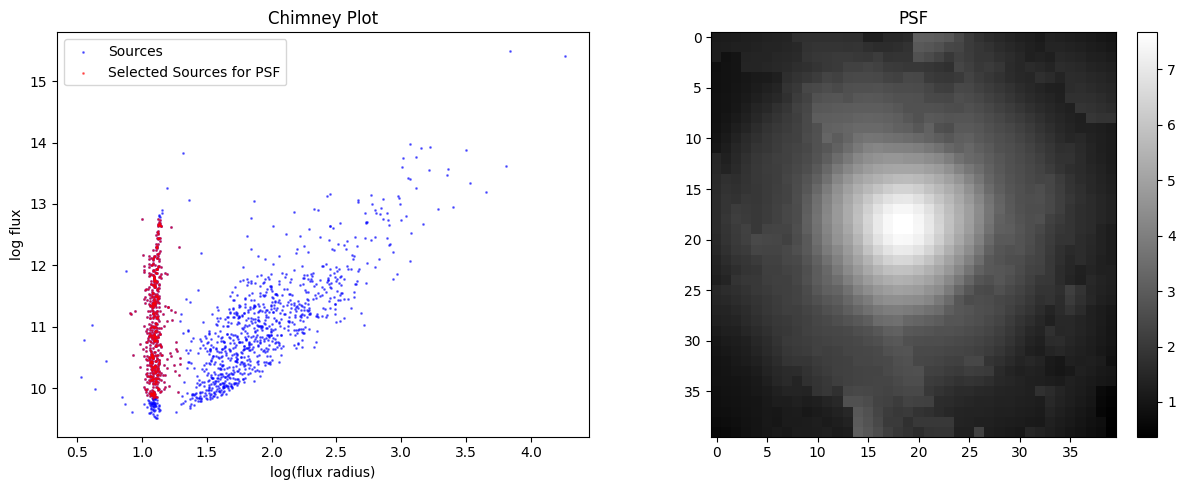

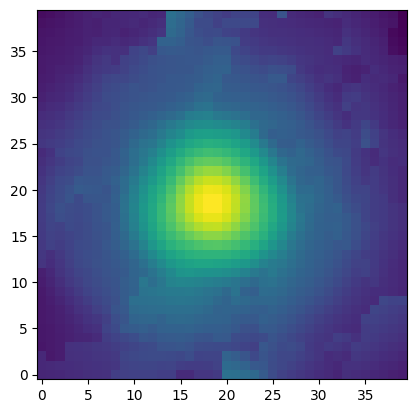

In [42]:
files = glob.glob(f'{location}/{field}/{filter}_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file, memmap=True) as hdul:
    hdu = hdul[0]
    image = hdu.data
    wcs = WCS(hdu.header)
catalog = Table.read(f'{location}/{field}/psf.cat', format="fits", hdu=2)
psf = create_psf(image, catalog, 40, plot_chimney=True, plot_psf=True, window_size=0.1, lower_percentile=10, upper_percentile=99, minimum_log_flux= 5)
plt.imshow(np.log10(psf), origin='lower', cmap='viridis')
plt.show()
plt.close("all")

In [29]:
import gc
gc.collect()

49866

90d12m04.85633819s


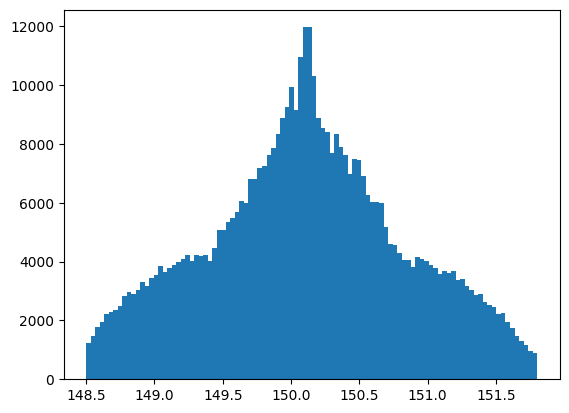

No Matches Found


In [61]:
RA, DEC = 58.9,	-48.6
my_source = SkyCoord(ra=RA, dec=DEC, unit=(u.deg, u.deg))

with fits.open(f"{location}/specz_compilation_COSMOS_DR1.1_all.fits") as hdul:
    compilation_ALL = hdul[1].data

coords_comp_ALL = SkyCoord(ra=compilation_ALL['ra_corrected'], dec=compilation_ALL['dec_corrected'], unit=(u.deg, u.deg))

d2d = my_source.separation(coords_comp_ALL)
print(min(d2d))
plt.hist(compilation_ALL['ra_corrected'], bins=100)
plt.show()
comp_ALL_mask = d2d < 100000.*u.arcsec

# Double Check if there are matches:
if True not in comp_ALL_mask:
    print("No Matches Found")
else:
    print(f"{comp_ALL_mask.sum()} Matches Found")

In [65]:
from matplotlib.colors import LogNorm
from astropy.cosmology import FlatLambdaCDM
from sklearn.neighbors import NearestNeighbors

In [62]:
def boxplot(RA_min,RA_max,DEC_min,DEC_max,z_min,z_max,ax):
    ###### DEFINE THE BOX
    # Define Vertices
    vertices = [
        [RA_min, DEC_min, z_min],  # Lower front left corner
        [RA_max, DEC_min, z_min],  # Lower front right corner
        [RA_max, DEC_max, z_min],  # Upper front right corner
        [RA_min, DEC_max, z_min],  # Upper front left corner
        [RA_min, DEC_min, z_max],  # Lower back left corner
        [RA_max, DEC_min, z_max],  # Lower back right corner
        [RA_max, DEC_max, z_max],  # Upper back right corner
        [RA_min, DEC_max, z_max]   # Upper back left corner
    ]

    # Use now to define the edges
    edges = [
        [vertices[0], vertices[1]],  # Bottom front edge
        [vertices[1], vertices[2]],  # Right front edge
        [vertices[2], vertices[3]],  # Top front edge
        [vertices[3], vertices[0]],  # Left front edge
        [vertices[4], vertices[5]],  # Bottom back edge
        [vertices[5], vertices[6]],  # Right back edge
        [vertices[6], vertices[7]],  # Top back edge
        [vertices[7], vertices[4]],  # Left back edge
        [vertices[0], vertices[4]],  # Left bottom front to left bottom back
        [vertices[1], vertices[5]],  # Right bottom front to right bottom back
        [vertices[2], vertices[6]],  # Right top front to right top back
        [vertices[3], vertices[7]]   # Left top front to left top back
    ]

    # Plot edges of box
    for edge in edges:
        x = [v[0] for v in edge]
        y = [v[1] for v in edge]
        z = [v[2] for v in edge]
        ax.plot(x, y, z, color='black',lw=0.5)


    return ax

In [63]:
cat = compilation_ALL

# Keep only those that have good quality flags and redshifts
these = (cat["specz"] > 0.1) & (cat["specz"] < 9.0) & ( ((cat["flag"] >= 2.) & (cat["flag"] <= 4.)) | ((cat["flag"] >= 12.) & (cat["flag"] <= 14.)) )
cat = cat[these]

In [66]:
# Define Cosmology
cosmo = FlatLambdaCDM(H0=70,Om0=0.3)

# Set the arcsec to pkpc scale
scale = cosmo.kpc_comoving_per_arcmin(cat["specz"]).value/(1e3*60.)

# Measure Offsets and convert in to a coordinate space (offset_RA, offset_DEC, and comoving distance)
# This will be used for measuring nearest neighbors
dRA = (cat["ra_corrected"]-150.)*3600.*scale; dDEC = (cat["dec_corrected"]-2.2)*3600.*scale; dist = cosmo.comoving_distance(cat["specz"]).value
coords = np.column_stack((dRA,dDEC,dist))

In [68]:
# Calculate to the 10th Nearest Neighbour
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)
max_distances = np.asarray([np.max(ii) for ii in distances]) #units already in Mpc
sigma_dens = 11./(4./3.*np.pi*max_distances**3.) # calculate comoving spherical number density

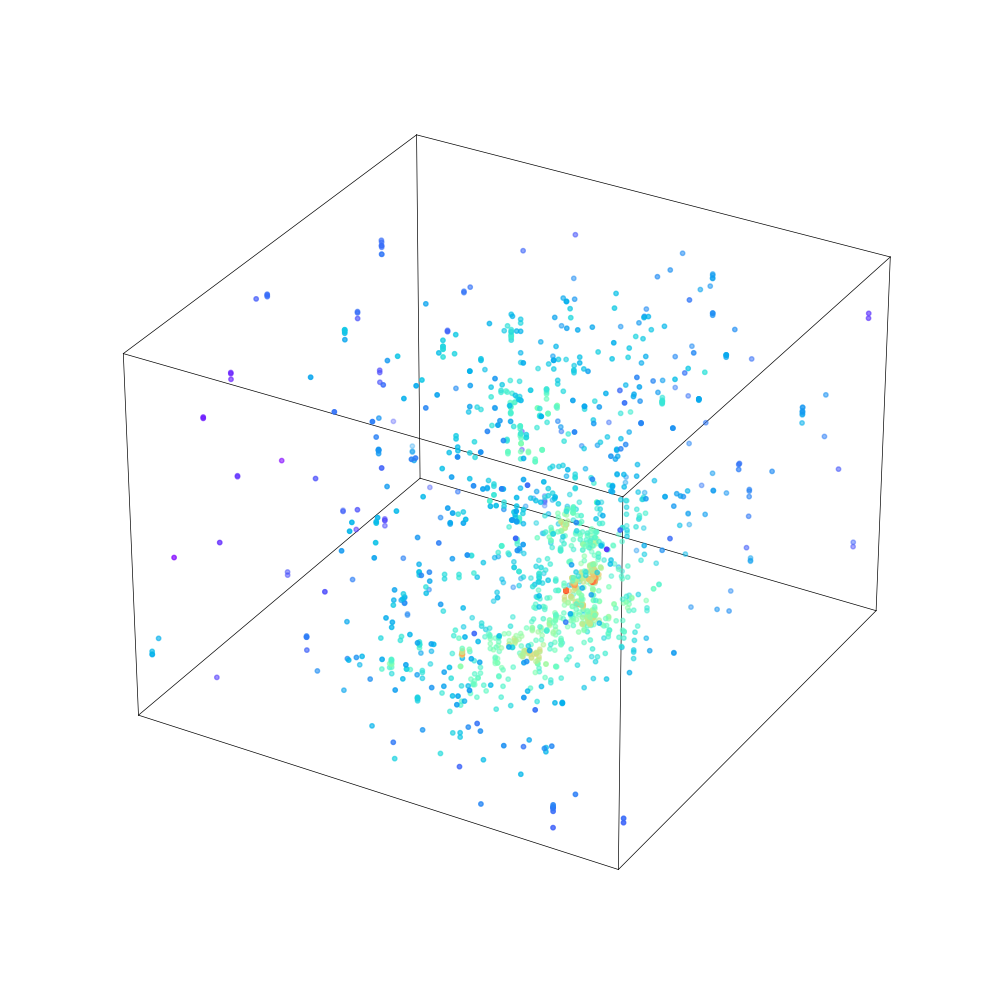

In [75]:
fig = plt.figure()
fig.set_size_inches(10,10)

fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.01, right=0.99, bottom=0.0, top=1.0)
ax = fig.add_subplot(1, 1, 1, projection='3d', facecolor="white")
ax.set_axis_off()
bbox = fig.bbox_inches.from_bounds(0.2, 0.8, 2.5, 1.6)

# RA, DEC, and Redshift limits
RA_min = 149.0; RA_max = 151.0
DEC_min = 1.75; DEC_max = 2.75
z_min = 2.42; z_max = 2.8
ang_scale = cosmo.kpc_comoving_per_arcmin(z_max).value/(1e3)*60.
cosm_dist = cosmo.comoving_distance(z_max).value - cosmo.comoving_distance(z_min).value

# Plot Box Plot
ax = boxplot(RA_min,RA_max,DEC_min,DEC_max,z_min,z_max,ax)


##### NOW PLOT THE GALAXIES
these_only = (cat["specz"] > z_min) & (cat["specz"] < z_max) & (cat['ra_corrected'] > RA_min) & (cat['ra_corrected'] < RA_max) & (cat['dec_corrected'] > DEC_min) & (cat['dec_corrected']< DEC_max) 
lss = ax.scatter(cat["ra_corrected"][these_only],cat["dec_corrected"][these_only],cat["specz"][these_only],c=sigma_dens[these_only], s=10, cmap="rainbow",norm=LogNorm())
plt.show()
plt.close("all")